In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

well_log = pd.read_csv('data/training_data.csv')

well_log['logF/logphi'] = well_log['ILD_log10'] / np.log10(well_log['PHIND'])

In [13]:
import seaborn as sns

data_columns = [label for label in list(well_log.columns) if label not in ('Well Name','Facies','Formation', 'Depth')]

plot_columns = [label for label in list(well_log.columns) if label not in ('Formation', 'Well Name','Facies', 'Depth', 'NM_M')]


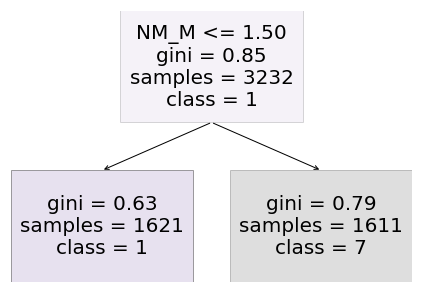

In [14]:
from sklearn import tree
from dtreeplt import dtreeplt

from sklearn import preprocessing


X = well_log[data_columns]
Y = well_log['Facies']

"""le = preprocessing.LabelEncoder()
le.fit(well_log['Formation'])

X['Formation'] = le.transform(well_log['Formation'])"""

model = tree.DecisionTreeClassifier(max_depth=1)
dt_fit = model.fit(X,Y)

dtree = dtreeplt(
    filled=True,
    model=model,
    feature_names=data_columns,
    target_names=list(range(9)),
    disp_values=False
)

fig = dtree.view()

In [15]:
well_log.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,logF/logphi
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,0.617046
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,0.601367
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,0.589812
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,0.585989
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,0.575699


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [20]:
blind_data = pd.read_csv('data/validation_data_nofacies.csv')

blind_data['logF/logphi'] = blind_data['ILD_log10'] / np.log10(blind_data['PHIND'])

X_blind = blind_data.drop(['Formation', 'Well Name', 'Depth'], axis=1).values
well_blind = blind_data['Well Name'].values
depth_blind = blind_data['Depth'].values



In [21]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import GradientBoostingClassifier

print('.' * 100)
y_pred = []
for seed in range(100):
    np.random.seed(seed)

    clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=6, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state = seed,
              subsample=0.4, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

    clf.fit(X_train, y_train)
    y_blind = clf.predict(X_blind)
    #y_blind = medfilt(y_blind, kernel_size=5)
    y_pred.append(y_blind)
    print('|', end='')

np.save('NS-Team_100_realizations.npy', y_pred)

....................................................................................................
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [25]:
PRED = pd.read_csv('data/prediction_depths.csv')
PRED.set_index(["Well Name", "Depth"], inplace=True)
PRED.head()

TRUE = pd.read_csv('data/blind_stuart_crawford_core_facies.csv')
TRUE.rename(columns={'Depth.ft': 'Depth'}, inplace=True)
TRUE.rename(columns={'WellName': 'Well Name'}, inplace=True)
TRUE.set_index(["Well Name", "Depth"], inplace=True)
TRUE.head()



LithCode     LithLabel
Well Name Depth                         
STUART    2807.5         3  NM Shly Silt
          2808.0         3  NM Shly Silt
          2808.5         3  NM Shly Silt
          2809.0         3  NM Shly Silt
          2809.5         3  NM Shly Silt

In [26]:
from sklearn.metrics import confusion_matrix

def get_accuracies(y_preds):
    """
    Get the F1 scores from all the y_preds.
    y_blind is a 1D array. y_preds is a 2D array.
    """
    accs = []
    for y_pred in y_preds:
        PRED['Facies'] = y_pred
        all_data = PRED.join(TRUE, how='inner')
        y_blind = all_data['LithCode'].values
        y_pred = all_data['Facies'].values
        y_pred = y_pred[y_blind!=11]
        y_blind = y_blind[y_blind!=11]
        cv_conf = confusion_matrix(y_blind, y_pred)
        #sns.heatmap(cv_conf, annot=True, fmt="d")
        accs.append(accuracy(cv_conf))
    return np.array(accs)

NS-Team             0.5231


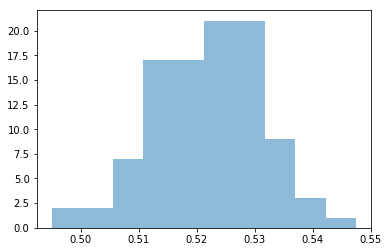

In [27]:
from os import path
from utils import accuracy
import operator

scores, medians = {}, {}
for f in ['NS-Team_100_realizations.npy']:
    team = path.basename(f).split('_')[0]
    y_preds = np.load(f)
    scores[team] = get_accuracies(y_preds)
    medians[team] = np.median(scores[team])
    plt.hist(pd.Series(scores[team]), alpha=0.5)

for t, m in sorted(medians.items(), key=operator.itemgetter(1), reverse=True):
    print("{:20s}{:.4f}".format(t, m))

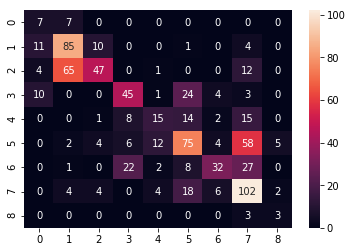

In [28]:
y_pred = y_preds[0]
PRED['Facies'] = y_pred
all_data = PRED.join(TRUE, how='inner')
y_blind = all_data['LithCode'].values
y_pred = all_data['Facies'].values
y_pred = y_pred[y_blind!=11]
y_blind = y_blind[y_blind!=11]
cv_conf = confusion_matrix(y_blind, y_pred)
sns.heatmap(cv_conf, annot=True, fmt="d")